# Capstone Project: Price Optimization (E-commerce)
#### The objective for this project is to find the most acceptable price range of different products, the target customer is Hong Kong based and E-commerce based.

## Quick introduction of the dataset
#### This data set is downloaded from the databank of a Hong Kong E-commerce website, the file has been combined by the daily sales record from 1-Jul-2022 to 31-Jul-2022.
#### The data contains 198,899 rows which was filtered by sub_cat_2_name_chi: Frozen/ Chilled Seafood.
#### There are 50 columns and data cleansing & feature extraction will be done as below.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
# Read the data set
data = pd.read_csv("Dataset.csv")

/Users/user/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (36,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Get the information of the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 51 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    198900 non-null  int64  
 1   membership_level              198900 non-null  object 
 2   order_date                    198900 non-null  object 
 3   order_time_range              198900 non-null  object 
 4   card_class                    123834 non-null  object 
 5   card_issuer                   128651 non-null  object 
 6   card_type                     198900 non-null  object 
 7   area                          151918 non-null  object 
 8   district                      151918 non-null  object 
 9   delivery_district             151918 non-null  object 
 10  delivery_zone                 151918 non-null  object 
 11  housing_type                  151917 non-null  object 
 12  order_value                   198900 non-nul

#### Looks like some of the columns contains too many null values, let's take a look of each of the columns.

In [4]:
# Check if these columns could be useful
print(data.iloc[:, [0, 2, 17, 18, 21, 26, 28, 30, 32, 33, 34, 37, 41, 44, 49, 50]])

        Unnamed: 0  order_date                                        sku_id  \
0            19398  2022-07-01  3Lho5Ta84IQGkONyVuvCSDxAMwPvX7X8rkmEkCdQczE=   
1            19399  2022-07-01  5XgZEwtYsxL5xfpLCaHlxNmaEwy7o0Sd5FuqUNBRfRU=   
2            19400  2022-07-01  3Lho5Ta84IQGkONyVuvCSDxAMwPvX7X8rkmEkCdQczE=   
3            19401  2022-07-01  Kjv+iONH0c+qOb2Aepk1GLj7ej62bTWbe/RZWu0nQH8=   
4            19402  2022-07-01  3Lho5Ta84IQGkONyVuvCSDxAMwPvX7X8rkmEkCdQczE=   
...            ...         ...                                           ...   
198895       19852  2022-07-31  +A/Ss+lustMMiqeXN67qBem7rqsfD2Vqnkc2puc1N1Y=   
198896       19853  2022-07-31  O++SDRQnPLqHQhVkr9xX/aiXfM1bYqKcYjiOyekaHyU=   
198897       19854  2022-07-31  O++SDRQnPLqHQhVkr9xX/aiXfM1bYqKcYjiOyekaHyU=   
198898       19855  2022-07-31  xNc4NCjidpsMwyvOMDE8AseauEOrwPtgQ8sIN53DR+s=   
198899       19856  2022-07-31  zgdHMuD2JiQCMQYHpjd4JjyjJX2kHYC8VZwLWpP5B5I=   

                                      p

#### Obviously, there are some columns which are not suitable to be the features.
#### So we have to drop those unsuitable columns with the reasons below: 
##### 1) column id, product_id have too many NULL values which could not be filled in by valuable values
##### 2) primary_sku_id is same as sku_id, so we only need one of those
##### 3) columns in chinese do not needed as eng version is good enough
##### 4) sub_cat_4 are all null values
##### 5) mall_level_promotion_amount has too many null values

In [5]:
# Drop unsuitable columns
data = data.drop(columns = ["Unnamed: 0", "product_id", "primary_sku_id", "brand_chi", "primary_category_name_chi", "sub_cat_1_name_chi", "sub_cat_2_name_chi", "sub_cat_3_name_chi", "sub_cat_4_name_en", "sub_cat_4_name_chi", "mall_level_promotion_amount", "packing_spec_chi", "size", "manufacturer_country_chi"])

In [6]:
# Check the new data: 50 columns -> 36 columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   membership_level              198900 non-null  object 
 1   order_date                    198900 non-null  object 
 2   order_time_range              198900 non-null  object 
 3   card_class                    123834 non-null  object 
 4   card_issuer                   128651 non-null  object 
 5   card_type                     198900 non-null  object 
 6   area                          151918 non-null  object 
 7   district                      151918 non-null  object 
 8   delivery_district             151918 non-null  object 
 9   delivery_zone                 151918 non-null  object 
 10  housing_type                  151917 non-null  object 
 11  order_value                   198900 non-null  object 
 12  total_discounts               198900 non-nul

#### There are many merchants would set different price in weekdays and weekends and this may affect the price range, so let's convert the date column to the more understandable columns: is_weekend

In [7]:
# Convert date to "is_weekend" column
data["order_date"] = data["order_date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date())

In [8]:
data["is_weekend"] = data["order_date"].apply(lambda x: "weekend" if x.weekday() > 4 else "weekday")

In [9]:
# Drop the date columns as "is_weekend" is created
data = data.drop(columns = "order_date")

#### Since the total_price column is object, it is difficult to manupulate and the range itself is discrete, it would be better to convert it to integer columns.

In [10]:
# Create integer columns for easier manipulating
data["total_price_from"] = data["total_price"].apply(lambda x: x.split("-")[0]).astype(float)
data["total_price_to"] = data["total_price"].apply(lambda x: x.split("-")[1]).astype(float)
data = data.drop(columns = ["total_price"])

#### With the converted columns, we could now dig in to the other columns easier.

In [11]:
# See do the left columns affect on the price range
# We would start from membership_level
print(data.groupby(by = "membership_level").mean())

                  cash_voucher_applied_value  paid_voucher_applied_value  \
membership_level                                                           
GOLDVIP                            50.072180                  168.047667   
NORMAL                             45.533425                  355.867039   
SENIOR                             25.674037                         NaN   
VIP                                44.941904                  260.047125   

                  quantity  sku_ready_required_days  total_price_from  \
membership_level                                                        
GOLDVIP           1.385316                 0.000333         74.164514   
NORMAL            1.330348                 0.001394         80.951300   
SENIOR            1.502618                 0.000000         82.306283   
VIP               1.395939                 0.003516         72.068465   

                  total_price_to  
membership_level                  
GOLDVIP               102.133637  

#### Looks like GOLDVIP and NORMAL are willing to pay more, but since GOLDVIP and VIP share the same discount and NORMAL has the higher paid_voucher_applied_value, membership_level looks like could not change the price range, but the voucher values do.

In [12]:
# Does order_time_range affects the price range?
print(data.groupby(by = "order_time_range").mean())

                  cash_voucher_applied_value  paid_voucher_applied_value  \
order_time_range                                                           
00-09                              49.965617                  224.272344   
09-12                              46.665494                  226.963049   
12-15                              47.804105                  240.378007   
15-18                              47.739774                  241.737458   
18-21                              46.364668                  237.171995   
21-24                              46.679943                  245.591111   

                  quantity  sku_ready_required_days  total_price_from  \
order_time_range                                                        
00-09             1.397209                 0.001532         70.937242   
09-12             1.396309                 0.001247         76.494737   
12-15             1.381096                 0.001410         78.523427   
15-18             1.357603

#### Looks like no big difference by different order time range. Besides, card_class, card_issuer and card_type do not affect the price range, so we would drop those columns together.

In [13]:
# Drop those columns which do not affect the price range
data = data.drop(columns = ["membership_level", "order_time_range", "card_class", "card_issuer", "card_type"])

In [14]:
# See if category cause any changs in price
print(data.groupby(by = "sub_cat_3_name_en").mean())

                        cash_voucher_applied_value  \
sub_cat_3_name_en                                    
Frozen Fish                              47.342815   
Frozen Seashell                          48.417760   
Frozen Shrimp and Crab                   48.088191   
Other Frozen Seafood                     47.166427   

                        paid_voucher_applied_value  quantity  \
sub_cat_3_name_en                                              
Frozen Fish                             236.444644  1.433940   
Frozen Seashell                         251.350244  1.231642   
Frozen Shrimp and Crab                  224.256000  1.342420   
Other Frozen Seafood                    226.418121  1.313662   

                        sku_ready_required_days  total_price_from  \
sub_cat_3_name_en                                                   
Frozen Fish                            0.001321         73.655018   
Frozen Seashell                        0.005316         92.101733   
Frozen Shrimp 

#### So different category would cause the price changes, we would like to keep it as a feature.

In [15]:
# See if packing box type cause any changs in price
print(data.groupby(by = "packing_box_type").mean())

                  cash_voucher_applied_value  paid_voucher_applied_value  \
packing_box_type                                                           
E                                  47.641544                  235.779655   
J                                  45.919316                  238.571429   

                  quantity  sku_ready_required_days  total_price_from  \
packing_box_type                                                        
E                 1.374755                 0.001777         75.320079   
J                 1.372180                 0.000000         38.537594   

                  total_price_to  
packing_box_type                  
E                     105.420185  
J                      43.231203  


#### The packing box type would also cause price changes, so we would keep it as a feature.

In [16]:
# Change the "bundle_set" column with Boolean
data["bundle_set"] = data["bundle_set"].notnull()
data["bundle_set"] = data["bundle_set"].apply(lambda x: int(x))

In [17]:
# Check how is this column now
print(data.groupby(by = "bundle_set").mean())

            cash_voucher_applied_value  paid_voucher_applied_value  quantity  \
bundle_set                                                                     
0                            47.548163                  236.352906  1.369481   
1                            58.211962                  192.500000  1.940120   

            sku_ready_required_days  total_price_from  total_price_to  
bundle_set                                                             
0                          0.001284         75.434463      105.690764  
1                          0.054437         57.723462       67.388949  


#### Providing a bundle set or not is obviously change the price range, so we would keep it as a feature.
#### We would have a look on geographic data now.

In [18]:
# Drop unsuitable columns ("delivery_district" is for internal uses and "delivery_zone" is same as district)
data = data.drop(columns = ["delivery_district", "delivery_zone"])

In [19]:
# Drop unsuitable columns ("area" is already enough for customer targeting)
data = data.drop(columns = ["district"])

In [20]:
# Handle the null values on these two columns
data["area"] = data["area"].fillna("NULL")
data["housing_type"] = data["housing_type"].fillna("NULL")

In [21]:
# Check whether living area and housing type would cause any differences
print(data.groupby(by = "area").mean())

      cash_voucher_applied_value  paid_voucher_applied_value  bundle_set  \
area                                                                       
HK                     47.922251                  208.658783    0.010615   
KLN                    47.642853                  222.112274    0.011745   
NT                     47.394147                  250.903111    0.012521   
NULL                   51.265495                  281.290323    0.000511   

      quantity  sku_ready_required_days  total_price_from  total_price_to  
area                                                                       
HK    1.397508                 0.001650         76.473932      106.335712  
KLN   1.395938                 0.001692         73.857742      102.082342  
NT    1.386896                 0.002036         71.631593       98.677135  
NULL  1.320995                 0.001469         82.006130      119.008556  


In [22]:
print(data.groupby(by = "housing_type").mean())

                              cash_voucher_applied_value  \
housing_type                                               
Commercial                                     42.805236   
HOS                                            45.452182   
House                                          67.345476   
NULL                                           51.265495   
Private                                        48.348081   
Public                                         49.575607   
Village/Villa/Tenement House                   48.764848   

                              paid_voucher_applied_value  bundle_set  \
housing_type                                                           
Commercial                                    203.972570    0.012369   
HOS                                           253.382937    0.012884   
House                                          60.000000    0.000000   
NULL                                          281.290323    0.000511   
Private                    

#### Looks like people live private and commercial housing in HK area are willing to afford better products with higher price. It could help in marketing strategy (For example, launching a pop-up store in shopping malls near that district, etc.) but unfortunately, these features could not cause any changes in price range so we would drop these columns.

In [23]:
# Drop area and housing type as these columns do not affect the price range
data = data.drop(columns = ["area", "housing_type"])

#### With the same reason of total_price, we would like to do the same thing to order_value for easier manipulation.

In [24]:
# Create integer columns for easier manupulating
data["order_value_from"] = data["order_value"].apply(lambda x: x.split("-")[0]).astype(float)
data["order_value_to"] = data["order_value"].apply(lambda x: x.split("-")[1]).astype(float)
data = data.drop(columns = ["order_value"])

#### Columns about the discounts are absoulutely affecting the price range but the amount is too discrete, so we would convert it to boolean, which means does any discounts provided.

In [25]:
# Create a column to see whether there had a discount
data["any_discounts"] = data["total_discounts"].apply(lambda x: 0 if (x == "0-0.5") else 1)
data = data.drop(columns = ["total_discounts"])

In [26]:
# Fill in NAN with 0
data["cash_voucher_applied_value"] = data["cash_voucher_applied_value"].fillna(0.00)
data["paid_voucher_applied_value"] = data["paid_voucher_applied_value"].fillna(0.00)

In [27]:
# Fill NaN values ("sku_level_promotion_amount")
data["sku_level_promotion_amount"] = data["sku_level_promotion_amount"].fillna(0.00)

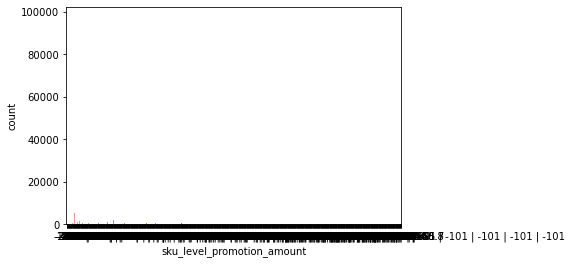

In [28]:
# See how the promotion_amount distribute
ax = sns.countplot(x="sku_level_promotion_amount", data=data)

#### As the sku_level_promotion_amount is too discrete, and this promotion is provided by the website itself, the actual amount is undefinable, we would drop this column out and use other discount related columns for further exploring.

In [29]:
# Drop unsuitable columns (Undefinable and cannot control)
data = data.drop(columns = ["sku_level_promotion_amount"])

In [30]:
# Change the "store_level_promotion_amount" column wiht Boolean 
data["store_level_promotion_amount"] = data["store_level_promotion_amount"].notnull()

In [31]:
data["store_promotion"] = data["store_level_promotion_amount"].apply(lambda x: int(x))
data = data.drop(columns = ["store_level_promotion_amount"])

#### Now, let us combine all the discount related columns into one, which only shows did any discounts applied in this sales record.

In [32]:
# Create column to see whether there had a voucher applied
def yes_no(x, y, z, w):
    if x > 0 or y > 0 or z > 0 or w > 0:
        return 1
    else:
        return 0
data["any_promotion"] = data.apply(lambda x: yes_no(x["cash_voucher_applied_value"], x["paid_voucher_applied_value"], x["any_discounts"], x["store_promotion"]), axis = 1)
data = data.drop(columns = ["cash_voucher_applied_value", "paid_voucher_applied_value", "any_discounts", "store_promotion"])

#### After exploring the discount related columns, we would like to explore the left columns one by one.

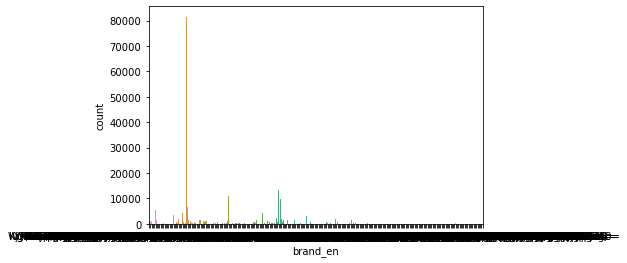

In [33]:
# Does brand_en affect any changes in price range?
ax = sns.countplot(x="brand_en", data=data)

#### Drop out brand_en (We cannot define what brand it is, the brand name has been encoded by the website)

In [34]:
data = data.drop(columns = ["brand_en"])

#### Quantity may causes changes in price range (Buy 2 get 1 free, etc.), so we would keep it as a feature as well.

In [35]:
data["quantity"] = data["quantity"].apply(lambda x: int(x))

#### There are some rows that the order_value is lower than the product_value, which is not make sense and we would like to exclude those rows out of our dataset.

In [36]:
# Update the data to exclude those record that the order_value is lower than the product_value
data = data.loc[(data["order_value_from"] > data["total_price_from"])]

#### Since we are done with the order_value columns, we would like to convert those columns into one column, the price range column which we are going to predict.

In [37]:
# Build a function to calculate the rounded (< 50, 100 each starts from 100) total_price which will be our y  (To be predicted)
def price_range(fr, to):
    if float(fr) == 0:
        return "FREE"
    fr = round(50 * round(float(fr) / 50))
    to = round(50 * round(float(to) / 50))
    if fr == to:
        fr -= 50
    if fr == 0:
        return "< 50"
    if fr < 0:
        return "FREE"
    else:
        return str(fr + 1) + "-" + str(to)

In [38]:
data["total_price_range"] = data.apply(lambda x: price_range(x["total_price_from"], x["total_price_to"]), axis = 1)

In [39]:
# Check whether the column converted correctly
data.loc[:, ["total_price_from", "total_price_to", "total_price_range"]]

,total_price_from,total_price_to,total_price_range
1,38.0,40.0,< 50
2,44.0,46.0,< 50
3,34.0,36.0,< 50
4,44.0,46.0,< 50
5,85.0,90.0,51-100
...,...,...,...
198895,46.0,48.0,< 50
198896,100.0,200.0,101-200
198897,85.0,90.0,51-100
198898,44.0,46.0,< 50


In [40]:
# Check the distribution of total_price_range
data["total_price_range"].value_counts()

< 50         82901
101-200      39041
51-100       35945
FREE         12608
201-300       7227
301-400       2104
401-500        729
501-600        277
601-700        102
701-800         62
801-900         31
901-1000        20
1001-1100        7
1101-1200        4
1401-1500        4
1301-1400        4
1201-1300        3
1601-1700        1
Name: total_price_range, dtype: int64

#### Seems the column has been converted sucessfully. However, the cost range is mostly at < 50 to 400, we need one more step to convert those rows with price range over 400 into > 401.

In [41]:
# Since the price range is mostly at < 50 to 400, we would like to convert those price range over 400 to > 401
def to_401 (x):
    try:
        if int(x.split("-")[0]) > 400:
            return "> 401"
        else:
            return x
    except:
        return x

In [42]:
data["total_price_range"] = data["total_price_range"].apply(lambda x: to_401(x))

In [43]:
# Check if the columns be converted correctly
data["total_price_range"].value_counts()

< 50       82901
101-200    39041
51-100     35945
FREE       12608
201-300     7227
301-400     2104
> 401       1244
Name: total_price_range, dtype: int64

#### The y column looks good now, we would drop the price columns later.
#### At the same time, the price range is relatively large after 100, but since the raw data is already built in such a large range, we could only continue by that.

#### How are the category columns look like?

In [44]:
# "primary_category"
data["primary_category"].value_counts()

AA11112010001    103423
AA11112020001     35364
AA11112030001     28343
AA11112090001     13940
Name: primary_category, dtype: int64

#### The primary_category is for internal usage.

In [45]:
# "primary_category_name_en"
data["primary_category_name_en"].value_counts()

Supermarket    181070
Name: primary_category_name_en, dtype: int64

In [46]:
# "sub_cat_1_name_en"
data["sub_cat_1_name_en"].value_counts()

Chilled/ Frozen Food    181070
Name: sub_cat_1_name_en, dtype: int64

In [47]:
# "sub_cat_2_name_en"
data["sub_cat_2_name_en"].value_counts()

Frozen Seafood    181070
Name: sub_cat_2_name_en, dtype: int64

In [48]:
# "sub_cat_3_name_en"
data["sub_cat_3_name_en"].value_counts()

Frozen Fish               103423
Frozen Shrimp and Crab     35364
Frozen Seashell            28343
Other Frozen Seafood       13940
Name: sub_cat_3_name_en, dtype: int64

#### All the category columns before 3 are with the same values, so we could drop those out of our data.

In [49]:
# Drop unsuitable columns (All with the same values)
data = data.drop(columns = ["primary_category", "primary_category_name_en", "sub_cat_1_name_en", "sub_cat_2_name_en"])

#### Since this dataset is base on frozen seafood, delivery date would affect the price range due to the storage and deliver issues.

In [50]:
# "sku_ready_required_days"
data["sku_ready_required_days"].value_counts()

0.0    180766
1.0       304
Name: sku_ready_required_days, dtype: int64

In [51]:
data["sku_ready_required_days"] = data["sku_ready_required_days"].astype(int)

#### Consigning the products to the website storage or not, share the same cost range and it won't affect to the price range.

In [52]:
# Drop is_consignment which won't affect the price range
data = data.drop(columns = ["is_consignment"])

#### Packing details would be important in price range, let's have a look on those columns.

In [53]:
# "packing_spec_en"
data["packing_spec_en"].value_counts()

300g                   22156
500g                   17185
480g                   14021
400g                   12608
454g                    7719
                       ...  
226.8g                     1
1/pkg/2pc                  1
10-12pcs, 500g/pack        1
300G (8PCS)                1
1/pkg/10pc                 1
Name: packing_spec_en, Length: 561, dtype: int64

In [54]:
# "weight"
data["weight"].value_counts()

520g      12282
300g      11021
502g       9211
508g       8272
500g       7690
          ...  
27g           1
226.8g        1
3.8kg         1
56g           1
239g          1
Name: weight, Length: 233, dtype: int64

In [55]:
# Drop packing_spec_en (Hard to classify and "weight" could do the same effect)
data = data.drop(columns = ["packing_spec_en"])

In [56]:
# "packing_box_type"
data["packing_box_type"].value_counts()
# E = Frozen Food (-18°C), J = Chill Food (0-4°C)

E    180810
J       260
Name: packing_box_type, dtype: int64

In [57]:
# Transfer the packing box type into strings which are easier to understand
data["packing_box_type"] = data["packing_box_type"].replace("E", "FROZEN")
data["packing_box_type"] = data["packing_box_type"].replace("J", "CHILL") 

In [58]:
# "storage_type"
data["storage_type"].value_counts()
# G = Frozen meet (Frozen <0°C), F = Chill e.g. Yogurt (Chill 0-4°C), J = Chill

G    116832
F       227
J        24
Name: storage_type, dtype: int64

In [59]:
# "packing_box_type" could do the same effect while "storage_type" has missing values, so we would drop storage_type out
data = data.drop(columns = ["storage_type"])

In [60]:
# "height"
data["height"].value_counts()

250mm      14439
35mm       10807
300mm      10796
200mm       9108
150mm       8370
           ...  
2100mm         1
16mm           1
245mm          1
580mm          1
30150mm        1
Name: height, Length: 130, dtype: int64

In [61]:
# "length"
data["length"].value_counts()

150mm    17101
200mm    13011
220mm    12717
190mm     8971
100mm     7928
         ...  
63mm         1
440mm        1
560mm        1
460mm        1
207mm        1
Name: length, Length: 128, dtype: int64

In [62]:
# "width"
data["width"].value_counts()

30mm     22037
50mm     14505
40mm     13538
20mm      8989
35mm      8424
         ...  
338mm        2
46mm         1
61mm         1
310mm        1
33mm         1
Name: width, Length: 120, dtype: int64

In [63]:
# Build a function to turn strings into integers
data["weight"] = data["weight"].map(lambda x: x.rstrip("g"))

In [64]:
# Convert kg to g
def to_g(x):
    if x[-1] == "k":
        x = x.rstrip("k")
        x = float(x) * 1000
    return x

In [65]:
data["weight"] = data["weight"].apply(to_g)

In [66]:
data["weight"] = data["weight"].astype(float)

In [67]:
# Change the size columns from string into integers and floats
data["height"] = data["height"].map(lambda x: x.rstrip('mm')).astype(int)
data["length"] = data["length"].map(lambda x: x.rstrip('mm')).astype(int)
data["width"] = data["width"].map(lambda x: x.rstrip('mm')).astype(float)

In [68]:
# Fill in Null values
data["manufacturer_country_en"] = data["manufacturer_country_en"].fillna("OTHERS")

#### Last but not least, we would like to explore the manufacturer country column.

In [69]:
# Change all the countries into uppercase to prevent duplicates
data["manufacturer_country_en"] = data["manufacturer_country_en"].apply(lambda x: x.upper())

In [70]:
# Replace values which duplicates with other the same country name
data["manufacturer_country_en"] = data["manufacturer_country_en"].replace({"VIET NAM" : "VIETNAM", 
                                                                           "USA" : "UNITED STATES OF AMERICA", 
                                                                           "JAPAN/CHINA" : "CHINA/JAPAN", 
                                                                           "US" : "UNITED STATES OF AMERICA", 
                                                                           "CANADA/CHINA" : "VARIOUS", 
                                                                           "香港" : "HONG KONG",
                                                                           "CANADA, USA, NORWAY, GREENLAND, RUSSIA(PROCESSED ORIGIN: CHINA)" : "VARIOUS", 
                                                                           "JAPAN/HONG KONG" : "VARIOUS", 
                                                                           "INDONESIA/JAPAN/POLAND" : "VARIOUS", 
                                                                           "CHINA/VIETNAM" : "VARIOUS", 
                                                                           "RUSSIA/HONG KONG" : "VARIOUS", 
                                                                           "JAPAN / TAIWAN" : "VARIOUS", 
                                                                           "UK/SCOTLAND" : "VARIOUS", 
                                                                           "MEXICO/UNITED STATUS OF AMERICA" : "VARIOUS", 
                                                                           "AUSTRALIA/HONDURAS" : "VARIOUS"})

In [71]:
# Have a look on how is the dataset now
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181070 entries, 1 to 198899
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sku_id                   181070 non-null  object 
 1   bundle_set               181070 non-null  int64  
 2   quantity                 181070 non-null  int64  
 3   sub_cat_3_name_en        181070 non-null  object 
 4   sku_ready_required_days  181070 non-null  int64  
 5   packing_box_type         181070 non-null  object 
 6   weight                   181070 non-null  float64
 7   height                   181070 non-null  int64  
 8   length                   181070 non-null  int64  
 9   width                    181070 non-null  float64
 10  manufacturer_country_en  181070 non-null  object 
 11  is_weekend               181070 non-null  object 
 12  total_price_from         181070 non-null  float64
 13  total_price_to           181070 non-null  float64
 14  orde

#### Due to the dataset is actually a sales record in July, there would be products which have been purchased over once, and according to other issues like:
##### 1) Did bundle set apply?
##### 2) Did the customer purchase more than 1 product?
##### 3) Did the customer purchase in weekends or weekdays?
##### 4) Did any promotions apply?
#### All these issues may cause the same product with different price range, we have to drop those duplicates out of our dataset, and of course, those with the same sku id have to be dropped out as well.

In [72]:
# Drop duplicates by "sku_id" and "is_weekend"
data = data.drop_duplicates(subset = ["sku_id", "bundle_set", "quantity", "is_weekend", "any_promotion"])

In [73]:
# See how many rows left after dropping duplicates
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 1 to 198899
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sku_id                   10204 non-null  object 
 1   bundle_set               10204 non-null  int64  
 2   quantity                 10204 non-null  int64  
 3   sub_cat_3_name_en        10204 non-null  object 
 4   sku_ready_required_days  10204 non-null  int64  
 5   packing_box_type         10204 non-null  object 
 6   weight                   10204 non-null  float64
 7   height                   10204 non-null  int64  
 8   length                   10204 non-null  int64  
 9   width                    10204 non-null  float64
 10  manufacturer_country_en  10204 non-null  object 
 11  is_weekend               10204 non-null  object 
 12  total_price_from         10204 non-null  float64
 13  total_price_to           10204 non-null  float64
 14  order_value_from     

#### Now we have already dropped out the duplicates, we have to drop out sku id which is also be encoded (cannot be defined), to prevent overfitting of our model.

In [74]:
# Drop sku_id to prevent overfitting
data = data.drop(columns = ["sku_id"])

#### Let's have a look on distrubutions of the features.

In [75]:
data["bundle_set"].value_counts(normalize = True)

0    0.989612
1    0.010388
Name: bundle_set, dtype: float64

In [76]:
data["quantity"].value_counts(normalize = True)

1     0.511172
2     0.251470
3     0.091827
4     0.065073
6     0.028518
5     0.022442
8     0.008428
10    0.007252
7     0.005978
9     0.002548
12    0.002450
14    0.000490
20    0.000490
11    0.000392
15    0.000294
16    0.000196
13    0.000196
30    0.000196
18    0.000196
17    0.000098
23    0.000098
40    0.000098
24    0.000098
Name: quantity, dtype: float64

In [77]:
data["sub_cat_3_name_en"].value_counts(normalize = True)

Frozen Fish               0.539004
Frozen Shrimp and Crab    0.192082
Frozen Seashell           0.148373
Other Frozen Seafood      0.120541
Name: sub_cat_3_name_en, dtype: float64

In [78]:
data["sku_ready_required_days"].value_counts(normalize = True)

0    0.999608
1    0.000392
Name: sku_ready_required_days, dtype: float64

In [79]:
data["packing_box_type"].value_counts(normalize = True)

FROZEN    0.996864
CHILL     0.003136
Name: packing_box_type, dtype: float64

In [80]:
data["weight"].value_counts(normalize = True)

500.0     0.098785
300.0     0.089377
250.0     0.051744
400.0     0.050372
200.0     0.046158
            ...   
249.0     0.000098
56.0      0.000098
27.0      0.000098
3800.0    0.000098
239.0     0.000098
Name: weight, Length: 226, dtype: float64

In [81]:
data["height"].value_counts(normalize = True)

200      0.115935
300      0.088985
100      0.083105
150      0.082811
250      0.069189
           ...   
245      0.000098
16       0.000098
420      0.000098
580      0.000098
30150    0.000098
Name: height, Length: 130, dtype: float64

In [82]:
data["length"].value_counts(normalize = True)

200    0.130341
100    0.121521
150    0.119071
180    0.047824
220    0.042924
         ...   
63     0.000098
253    0.000098
460    0.000098
207    0.000098
560    0.000098
Name: length, Length: 128, dtype: float64

In [83]:
data["width"].value_counts(normalize = True)

50.0     0.150921
30.0     0.131321
20.0     0.094669
40.0     0.070855
100.0    0.070169
           ...   
46.0     0.000098
147.0    0.000098
61.0     0.000098
310.0    0.000098
33.0     0.000098
Name: width, Length: 120, dtype: float64

In [84]:
data["manufacturer_country_en"].value_counts(normalize = True)

CHINA                          0.218052
JAPAN                          0.132105
VIETNAM                        0.101627
NORWAY                         0.096629
CANADA                         0.056056
THAILAND                       0.055762
NEW ZEALAND                    0.034104
HONG KONG                      0.033516
UNITED STATES OF AMERICA       0.028714
TAIWAN                         0.028714
KOREA                          0.027538
INDONESIA                      0.026656
CHILE                          0.026264
MALAYSIA                       0.019208
AUSTRALIA                      0.017836
ICELAND                        0.010094
GREENLAND                      0.007350
FRANCE                         0.007252
VARIOUS                        0.006566
OTHERS                         0.006370
BRAZIL                         0.005880
INDIA                          0.005782
UNITED KINGDOM                 0.003430
ARGENTINA                      0.003332
SINGAPORE                      0.003332


In [85]:
data["is_weekend"].value_counts(normalize = True)

weekday    0.685809
weekend    0.314191
Name: is_weekend, dtype: float64

In [86]:
data["any_promotion"].value_counts(normalize = True)

0    0.561054
1    0.438946
Name: any_promotion, dtype: float64

#### Looks every columns are settled, we could drop the price columns now.

In [87]:
# Drop the columns after calculated
data = data.drop(columns = ["total_price_from", "total_price_to", "order_value_from", "order_value_to"])

In [88]:
# Final information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 1 to 198899
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bundle_set               10204 non-null  int64  
 1   quantity                 10204 non-null  int64  
 2   sub_cat_3_name_en        10204 non-null  object 
 3   sku_ready_required_days  10204 non-null  int64  
 4   packing_box_type         10204 non-null  object 
 5   weight                   10204 non-null  float64
 6   height                   10204 non-null  int64  
 7   length                   10204 non-null  int64  
 8   width                    10204 non-null  float64
 9   manufacturer_country_en  10204 non-null  object 
 10  is_weekend               10204 non-null  object 
 11  any_promotion            10204 non-null  int64  
 12  total_price_range        10204 non-null  object 
dtypes: float64(2), int64(6), object(5)
memory usage: 1.1+ MB


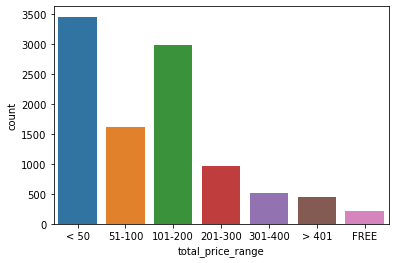

In [89]:
# Let's have a look on the label distribution
ax = sns.countplot(x="total_price_range", data=data)

### The data cleansing and EDA process is finished and below would be a brief description of our cleaned data set:
#### Features:
#### 1) About the product itself:
####    a) sub_cat_3_name_en
####    b) manufacturer_country_en
####    c) weight
####    d) height
####    e) length
####    f) width
#### 2) About delivery:
####    a) sku_ready_required_days
####    b) packing_box_type
#### 3) About promotion strategy:
####    a) bundle_set
####    b) is_weekend
####    c) any_promotion
####    d) quantity
#### y Label (To be predicted):
#### total_price_range

## We are ready to build the machine learning model now, so let's save the dataset into a new file.

In [90]:
# Convert to a new csv file
data.to_csv("Dataset_cleaned.csv")

## Building machine learning models

### As the data type of our y label is object, we would like to solve our problem by building classification models. In this project, we would apply two classification models: SVM and XGBoost.

#### Read the data and prepare X/ y

In [91]:
# Read the data
data = pd.read_csv("Dataset_cleaned.csv")

In [92]:
# Drop the id column
data = data.drop(columns = ["Unnamed: 0"])

In [93]:
# Prepare X and y
X = data.drop("total_price_range", axis = 1)  
y = data["total_price_range"]

#### Feature extractions

In [94]:
# Get dummies (Feature Extraction)
X_dummies = pd.get_dummies(X[["sub_cat_3_name_en", "packing_box_type", "manufacturer_country_en", "is_weekend"]], drop_first = True)

In [95]:
# Join the feature extracted data frame to the original one
train_X = pd.concat([X, X_dummies], axis = 1).drop(columns = ["sub_cat_3_name_en", "packing_box_type", "manufacturer_country_en", "is_weekend"], axis =1 )

#### Standarize the dataset

In [96]:
# Standarization
X_train_Standard = StandardScaler().fit_transform(train_X)

In [97]:
# Split the train test data set
X_train, X_test, y_train, y_test = train_test_split(X_train_Standard, y, test_size = 0.3, random_state = 42)

#### XGBoost

In [98]:
# Build a XGBoost model
# The parameters have been tuned manually by max_depth = [5, 6, 7, 8, 9, 10], learning_rate = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4],
# min_child_weight = [1, 2, 3], gamma = [0.5, 0.1, 0.15, 0.2], and finally the parameters as below had the best performance.
# P.S. The process of tuning parameters have been deleted from this notebook to save the code's running time
model = xgb.XGBClassifier(max_depth = 6, learning_rate = 0.3, min_child_weight = 1, gamma = 0.15)
model.fit(X_train, y_train)
print(model)

# make predictions for test data
X_pred_test_XG = model.predict(X_train)
y_pred_test_XG = model.predict(X_test)

# evaluate predictions
acc_train_XG = accuracy_score(y_train, X_pred_test_XG)
print("Train Accuracy:", acc_train_XG)
acc_val_XG = accuracy_score(y_test, y_pred_test_XG)
print("Test Accuracy:", acc_val_XG)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:08:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.15, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
Train Accuracy: 0.8937272472696723
Test Accuracy: 0.728282168517309


In [99]:
# Check the classification report
print(classification_report(y_test, y_pred_test_XG, zero_division = 0))

              precision    recall  f1-score   support

     101-200       0.67      0.79      0.72       867
     201-300       0.67      0.50      0.57       307
     301-400       0.62      0.48      0.54       176
      51-100       0.67      0.46      0.55       455
        < 50       0.81      0.91      0.86      1045
       > 401       0.77      0.69      0.73       147
        FREE       0.90      0.68      0.77        65

    accuracy                           0.73      3062
   macro avg       0.73      0.64      0.68      3062
weighted avg       0.72      0.73      0.72      3062



In [100]:
#Confusion Matrics - Recall Precision
print(confusion_matrix(y_test, y_pred_test_XG))

[[688  26  11  53  78  11   0]
 [116 152  18   9   7   5   0]
 [ 45  31  85   0   1  14   0]
 [122   6   1 210 116   0   0]
 [ 45   2   1  42 950   0   5]
 [ 15  10  21   0   0 101   0]
 [  0   0   0   0  21   0  44]]


#### The accuracy of test data is about 73%, and that of train data is about 89%. Althought the accuracies for 51 - 100, 201 - 300, 51 - 100 are relatively low, the overall performance of this model is quite good but there may be some overfitting problem which should be aware.

#### And according to the confusion matrix, looks like:
#### 1) 201-300 is easily to be predicted as 101-200 incorrectly
#### 2) 301-400 is easily to be predicted as 101-200 or 201-300 incorrectly
#### 3) 51-100 is easily to be predicted as 101-200 or <50 incorrectly
#### Which means these three labels would be easily predicted to the one upper or lower price range incorrectly, and it is relatively make sense.

#### SVM

In [101]:
# Build SVM Model
# Grid search has been applied for finding the best kernel, but that process has been deleted to save time for running code

clf_rbf = SVC(kernel = "rbf")
clf_rbf.fit(X_train, y_train)

y_pred_train_SVM_rbf = clf_rbf.predict(X_train)
y_pred_val_SVM_rbf = clf_rbf.predict(X_test)

In [102]:
# Compare the accuracy

acc_train_SVM_rbf = accuracy_score(y_train, y_pred_train_SVM_rbf)
acc_val_SVM_rbf = accuracy_score(y_test, y_pred_val_SVM_rbf)
print("Accuracy for Train (SVM_rbf): {0}, Accuracy for Val (SVM_rbf): {1}". format(acc_train_SVM_rbf, acc_val_SVM_rbf))

Accuracy for Train (SVM_rbf): 0.5456454774572949, Accuracy for Val (SVM_rbf): 0.5280862181580667


In [103]:
# Check the classification report
print(classification_report(y_test, y_pred_val_SVM_rbf, zero_division = 0))

              precision    recall  f1-score   support

     101-200       0.43      0.75      0.55       867
     201-300       0.38      0.04      0.07       307
     301-400       0.25      0.02      0.03       176
      51-100       0.62      0.01      0.02       455
        < 50       0.62      0.86      0.72      1045
       > 401       0.72      0.32      0.44       147
        FREE       0.17      0.02      0.03        65

    accuracy                           0.53      3062
   macro avg       0.46      0.29      0.27      3062
weighted avg       0.52      0.53      0.44      3062



In [104]:
#Confusion Matrics - Recall Precision
print(confusion_matrix(y_test, y_pred_val_SVM_rbf))

[[654   3   1   0 204   5   0]
 [269  11   3   0  20   4   0]
 [149   8   3   0   7   9   0]
 [202   0   0   5 247   0   1]
 [142   0   0   3 896   0   4]
 [ 87   7   5   0   1  47   0]
 [  2   0   0   0  62   0   1]]


#### The accuracy for both train and test data are highly decreased which most of the results have been predicted to 101-200 or < 50 which make the overall accuracies of the other labels are extremely low. The problem of overfitting in SVM model may be better than XGBoost, but due to the higher accuracy of XGBoost model, we would choose XGBoost as our finalized model.

In [105]:
# Save the model
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

#### Let's try to apply our built model to see what should be the price range of our new products.

#### A quick guide on how to prepare a "product_list.csv":

#### Prepare a csv file named "product_list.csv" with below columns and related values:
#### 1) bundle_set: If the product is going to be sold in a bundle set, set 1, else set 0.                 
#### 2) quantity: Enter the number for sell quantity                   
#### 3) sub_cat_3_name_en: Choose one of these categories: a) Frozen Fish b) Frozen Shrimp and Crab c) Frozen Seashell d) Other Frozen Seafood
#### 4) sku_ready_required_days: Enter 0 or 1   
#### 5) packing_box_type: Enter FROZEN or CHILL       
#### 6) weight: Enter the number of weight in g                   
#### 7) height: Enter the number of height in mm                     
#### 8) length: Enter the number of height in mm                     
#### 9) width: Enter the number of height in mm                    
#### 10) manufacturer_country_en: Enter the manufactuter country in upper case (Like CHINA, JAPAN, etc.)   
#### 11) is_weekend: If the product is going to be sold in a weekend, set 1, else set 0.               
#### 12) any_promotion: If any promotion applied, set 1, else set 0.

In [106]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [107]:
# load the product list
x = pd.read_csv("product_list.csv")

In [108]:
# feature extraction
x_dummies = pd.get_dummies(x[["sub_cat_3_name_en", "packing_box_type", "manufacturer_country_en", "is_weekend"]])
predict_x = pd.concat([x, x_dummies], axis = 1).drop(columns = ["sub_cat_3_name_en", "packing_box_type", "manufacturer_country_en", "is_weekend"], axis =1 )

In [109]:
# Add other feature columns with 0 to prevent shape error
features = []
for i in train_X.columns:
    features.append(i)
for i in predict_x.columns:
    if i in features:
        features.remove(i)
for feature in features:
    # Create a list of 0 with the number of products
    a = [0, 0, 0, 0, 0, 0, 0, 0]
    predict_x[feature] = a
# Drop duplicated columns
predict_x = predict_x.drop(columns = ["is_weekend_weekend", "sub_cat_3_name_en_Other Frozen Seafood"])

In [110]:
# Standarization
x_predict_standard = StandardScaler().fit_transform(predict_x)

In [111]:
# Predict the price range
y_predict = loaded_model.predict(x_predict_standard)

In [112]:
# Print out the result
result = pd.DataFrame(y_predict)
print(result)

         0
0     < 50
1     < 50
2  101-200
3  101-200
4  101-200
5  101-200
6  101-200
7   51-100


#### So here are the predicted results of our new products! However, can we do any improvements in our model?

#### Definitely yes!

#### We can do something more as below to help the model with better performance:
#### 1) Break down the category in more detailed: Shrimp/ crab, raw/ cooked, etc.
#### 2) Collect more data in different seasons to increase the quantity of features: Winter, summer, etc.
#### 3) Collect product information by web crawling with NLP like sold quantity, comment review, etc., by doing this, we may crawl the exact price of a product which may help us in setting a smaller price range and a more precised data set!

#### Guess these could help to increase the model accuracy!

#### Also, we could add in some more features to create some instant results for price decision.
#### 1) By adding some cost related features like delivery cost and storage cost, we could see if the profit earned by one product is worth to be sold. If the profit is too low which need to be sold in extremely high quantity to earn stable profit, we may decide not to sell that product.
#### 2) We may also add some dynamic pricing strategy in it, which means to tune the price according to the competitor's price, if our competitors sell the product in a high price range, it will be fine for us to tune the price range to the relatively high, but a bit lower than that of our competitors. This could be achived by adding a feature about the competitor's pricing.

#### A extended side project from this project: We may apply a NLP model to find a product category list whihc has less competitors!

#### Looks like there are so many things that could be explore from this project!